## cupyとかchainerとかの環境設定

In [5]:
!pip freeze
!curl https://colab.chainer.org/install | sh -
!apt -y -qq install graphviz > /dev/null 2> /dev/null
!pip install pydot

absl-py==0.6.1
altair==2.2.2
astor==0.7.1
atomicwrites==1.2.1
attrs==18.2.0
beautifulsoup4==4.6.3
bleach==3.0.2
cachetools==3.0.0
certifi==2018.11.29
chardet==3.0.4
crcmod==1.7
cycler==0.10.0
cymem==2.0.2
cytoolz==0.9.0.1
decorator==4.3.0
defusedxml==0.5.0
dill==0.2.8.2
entrypoints==0.2.3
future==0.16.0
gast==0.2.0
google-api-core==1.6.0
google-api-python-client==1.6.7
google-auth==1.4.2
google-auth-httplib2==0.0.3
google-auth-oauthlib==0.2.0
google-cloud-bigquery==1.1.0
google-cloud-core==0.28.1
google-cloud-language==1.0.2
google-cloud-storage==1.8.0
google-cloud-translate==1.3.1
google-colab==0.0.1a1
google-resumable-media==0.3.1
googleapis-common-protos==1.5.5
grpcio==1.15.0
h5py==2.8.0
httplib2==0.11.3
ideep4py==2.0.0.post3
idna==2.6
intel-openmp==2019.0
ipykernel==4.6.1
ipython==5.5.0
ipython-genutils==0.2.0
Jinja2==2.10
joblib==0.13.0
jsonschema==2.6.0
jupyter-client==5.2.3
jupyter-core==4.4.0
Keras==2.2.4
Keras-Applications==1.0.6
Keras-Preprocessing==1.0.5
Markdown==3.0.1
Mark

## fashionmnistのダウンロード

In [6]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = get_fashion_mnist(withlabel=True, ndim=1)

# 諸々のライブラリさん

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt,pydot
import numpy as np
import pandas as pd
import seaborn as sns
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import Chain
from IPython.display import Image, display

In [0]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, batchsize, device):
    
    # 1. deviceがgpuであれば、gpuにモデルのデータを転送する
    if device >= 0:
        model.to_gpu(device)
        
    # 2. Optimizerを設定する
    optimizer.setup(model)
    
    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)
    
    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    
    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    # 6. 訓練を開始する
    trainer.run()

In [0]:
train, validation = chainer.datasets.split_dataset_random(train, 50000, seed=0)

## んしゃっAlexNet作ったろ！！！(fashionmnist用に改良)


In [0]:
class AlexNet(Chain):
    def __init__(self):
      super(AlexNet, self).__init__()
      with self.init_scope():
        self.c1 = L.Convolution2D(1, 16, 5,2)
        self.c2 = L.Convolution2D(None,32,3,1)
        self.c3 = L.Convolution2D(None,64,3,1)
        self.fc1 = L.Linear(None,256)
        self.fc2 = L.Linear(None,256)
        self.fc3 = L.Linear(None,10)
    def forward(self,x):
      h = F.relu(self.c1(x.reshape((-1, 1, 28, 28))))
      h = F.local_response_normalization(h)
      h = F.max_pooling_2d(h,2,stride=2)
      h = F.relu(self.c2(h))
      h = F.relu(self.c3(h))
      h = F.local_response_normalization(h)
      h = F.max_pooling_2d(h,3,2,1)
      h = F.dropout(F.relu(self.fc1(h)))
      h = F.dropout(F.relu(self.fc2(h)))
      return self.fc3(h)
  

In [0]:
def show_loss_and_accuracy():
    display(Image(filename='out/loss.png'))
    display(Image(filename='out/accuracy.png'))

In [27]:

device = 0
n_epoch = 50
batchsize = 256

model = AlexNet()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.977665    0.632394       0.610531       0.752539           4.66699       
2           0.592184    0.776162       0.507395       0.807031           9.69415       
3           0.502458    0.816366       0.460142       0.828027           14.7599       
4           0.450145    0.837771       0.414266       0.843262           19.8652       
5           0.413693    0.853305       0.382949       0.856836           25.2729       
6           0.383292    0.863001       0.372321       0.863867           30.3611       
7           0.364823    0.869798       0.359762       0.865723           35.4048       
8           0.345576    0.87518        0.381811       0.858105           40.3489       
9           0.327596    0.880188       0.344276       0.876074           45.3081       
10          0.314574    0.885204       0.33333        0.879785           50.4078       
11          0.304449    0.88772   

In [0]:
def show_graph():
    graph = pydot.graph_from_dot_file('out/cg.dot') # load from .dot file
    graph[0].write_png('graph.png')
    display(Image('graph.png', width=600, height=600))


In [0]:
#show_graph()

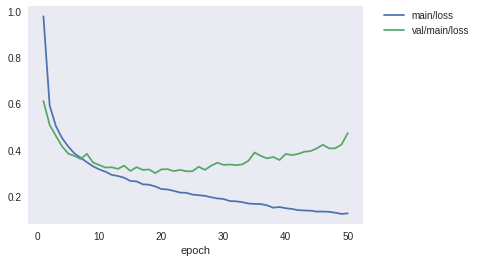

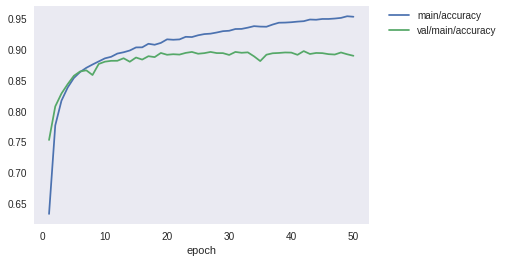

In [28]:
show_loss_and_accuracy()

In [0]:
def show_test_performance(model, test, device, batchsize=256):
    if device >=0:
        model.to_gpu()
    test_iter = chainer.iterators.SerialIterator(
        test, batchsize, repeat=False, shuffle=False
    )
    test_evaluator = extensions.Evaluator(test_iter, model, device=device)
    results = test_evaluator()
    print('Test accuracy:', results['main/accuracy'])

In [29]:
show_test_performance(classifier_model, test, device)

Test accuracy: 0.89091796
